In [1]:
from __future__ import division
import numpy as np
from scipy.integrate import solve_ivp
from scipy import interpolate 
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import date
import datetime
import seaborn as sns
from myfunctions_multi_scale import *
%matplotlib inline

In [2]:
# Import of I data
# irradiance data is based on meteorological data from: https://ims.data.gov.il/he/ims/6 
dFI = pd.read_csv('../data/ims_data_2014_umol_photons.csv',encoding= 'unicode_escape',header=None)
days = list(range(1,366))

In [3]:
# assign light data into an array for annual T and I plot

I_plot = np.zeros(24*365)
light_hours = list(range(5,19))
for day in days:
    for hour in light_hours:
        I_plot[(day - 1)*24 + hour] = float(dFI.iloc[day][hour-1])

annual_hours = list(range(1,(366-1)*24+1))
f0 = interpolate.interp1d(annual_hours, I_plot,kind = 'linear')

January 16
February 17
March 19
April 24
May 25
June 26
July 28
August 29
September 29.5
October 25
November 21
December 18


[Text(0, 0, '1 Jan'),
 Text(0, 0, '1 February'),
 Text(0, 0, '1 March'),
 Text(0, 0, '1 April'),
 Text(0, 0, '1 May'),
 Text(0, 0, '1 June'),
 Text(0, 0, '1 July'),
 Text(0, 0, '1 August'),
 Text(0, 0, '1 September'),
 Text(0, 0, '1 October'),
 Text(0, 0, '1 November'),
 Text(0, 0, '1 December')]

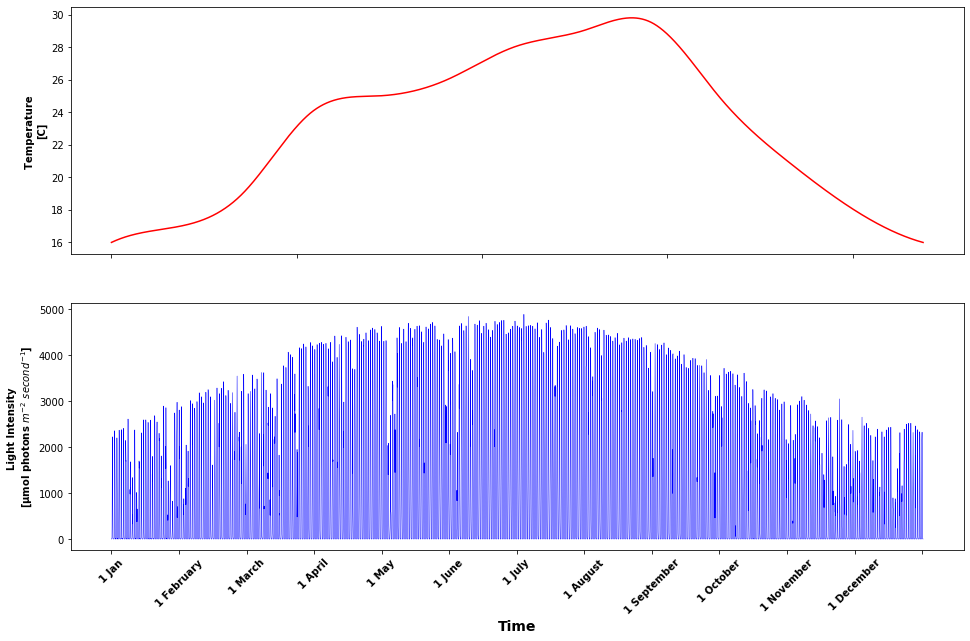

In [4]:
# T and light data

x1 = pd.ExcelFile('../data/input.xlsx')

dfT = x1.parse('T_multi-scale',header=None)
# Temperatures are water temperatures, taken from:
# Y. Suari, et al., Sandbar Breaches Control of the Biogeochemistry of a Micro-Estuary RIME-restoration of
# Israeli micro estuaries. Front. Mar. Sci. (2019) 

days_reduced,hours_reduced = [],[]
for i in range(1,13):
    day = datetime.datetime(2014, i, 1)
    days_reduced.append(int(day.strftime("%j")))

days_reduced.append(366)
for j in range(1,13):
    day = datetime.datetime(2014, j, 1)
    hours_reduced.append((int(day.strftime("%j"))-1)*24)
hours_reduced.append((366-1)*24)
T = []

# assigmment of parameters to values: 
for key,val in zip(dfT.iloc[1:][0],dfT.iloc[1:][1]):
    exec(key + '=val')
    T.append(val)
    print(key,val)
T.append(T[0])
days = list(range(1,366))

f1 = interpolate.interp1d(hours_reduced, T,kind = 'cubic')
T_interp = f1(annual_hours)

fig, ax = plt.subplots(2,1,figsize=(16,10))
xlabels = ['1 Jan', '1 February', '1 March', '1 April', '1 May', '1 June', '1 July', '1 August', '1 September', '1 October','1 November', '1 December']

ax[0].plot(annual_hours,T_interp, 'r-')
ax[1].plot(annual_hours,I_plot, 'b-', linewidth=0.5)

ax[1].set_xlabel('Time',fontsize=14, weight="bold")
ax[0].set_ylabel('Temperature \n[C]',fontsize=10, weight="bold")
ax[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=10, weight="bold")
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[1].set_xticks(annual_hours[0:len(annual_hours):int(len(annual_hours)/12-1)])
ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

In [5]:
I = np.zeros(24*365)
light_hours = list(range(5,19))
for day in days:
    for hour in light_hours:
        I[(day - 1)*24 + hour] = 0.43 * float(dFI.iloc[day][hour-1])

annual_hours = list(range(1,(366-1)*24+1))
f0 = interpolate.interp1d(annual_hours, I,kind = 'linear')

In [6]:
# assign light data into an array for simulations

df1 = x1.parse('Parameters_multi-scale',header=None)

# assigmment of parameters to values: 
for key,val in zip(df1.iloc[:][0],df1.iloc[:][1]):
    exec(key + '=val')
    print(key,val)

n_reactors = np.int(n_reactors)

umol_to_percent_DW 0.0014
n_days 14.0
Next0 500.0
Nint0 1.85
m0 0.15
S 30.0
Nintcrit 2.002
n_reactors 541.0
Qp 459.5833333333333
Qsea 7775.568181818181
Nsea 500.0
dilution 0.0
miu 0.027
Nintmax 4.2
Nintmin 0.7
KN 1.2
Ks 14.0
Vmax 60.0
Z 1.0
KI 20.0
K0 1.5
Ka 0.15
Topt 18.0
Tmin 5.0
Tmax 31.5
n 2.0
losses20 0.0016
teta 1.047
Sopt 18.0
Smin 0.0
Smax 45.0
Shigh 30.0
Slow 12.0


In [7]:
# year-round biomass production - calculate Mean productivity and N sequestration
n_reactors = 100
NSEA, NEXT, NINT, M, Total_N, T = [],[],[],[],[],[]
Total_biomass = []
N_normalized = []

print('Starting point')

# setup initial conditions identical for all reactors
x0 = n_reactors*[Nsea, Next0, Nint0, m0]

# time axis is in hours

dilution = 0
weeks = list(range(1,52,2)) 
for week0 in weeks:
    t0 = 10 + 7 * 24 * (week0 - 1)
    t = list(range(t0,t0 + int(n_days*24)))
    times = list(range(t0,t0 + int(n_days*24)))
    args = (Nintcrit,Nintmax,Nintmin,Vmax,Ks,KN,miu,Shigh,Z,KI,K0,Ka,Topt,Tmin,Tmax,losses20,
            teta,Sopt,Smin,Smax, Qp, Qsea, Nsea,f1,f0,dilution,n,umol_to_percent_DW)

    # solve the ODEs using the new syntax
    sol = solve_ivp(multi_N_f_un, [t[0], t[-1]], x0, args=args, t_eval = t)

    # take the solution of the state variables:
    M_farm = []
    N_farm = []
    Ni_farm,Nf_farm = [],[]
    for i in range(n_reactors):
        NSEA.append(sol.y[i*4,:])
        NEXT.append(sol.y[i*4+1,:])
        NINT.append(sol.y[i*4+2,:])
        M.append(sol.y[i*4+3,:])
        M_farm.append((M[-1][-1] - m0) * 1.785)
        N_farm.append((M[-1][-1] * NINT[-1][-1] - m0 * Nint0) * 1.785 / 100)
        Ni_farm.append(NINT[0][-1])
        Nf_farm.append(NINT[-1][-1])
    Total_biomass.append(round(sum(M_farm),2))
    Total_N.append(round(sum(N_farm),4))

    T.append(sol.t)

print("Done")

Mean_biomass_yield = [round((i * 1000 / (2 * n_reactors)) / n_days,4) for i in Total_biomass] #[g DW / m2 / day]
N_normalized = [round((i * 1000 / (2 * n_reactors)) / n_days,4) for i in Total_N] #[g N / m2 / day]
Mean_DGR = [100 * (i * n_days * (2 / 1.785) / (m0 * 1000 * n_days)) for i in Mean_biomass_yield]

np.savetxt('Mean_biomass_yield_100cages.csv',Mean_biomass_yield,delimiter=',')
np.savetxt('Mean_N_sequestration_100cages.csv',N_normalized,delimiter=',')
np.savetxt('Mean_DGR_100cages.csv',Mean_DGR,delimiter=',')
np.savetxt('Total_biomass_production_100cages.csv',Total_biomass,delimiter=',')
np.savetxt('Total_N_sequestration_100cages.csv',Total_N,delimiter=',')

Starting point
Done


In [8]:
# year-round biomass production - calculate Mean productivity and N sequestration + 5% dilution
n_reactors = 100
NSEA, NEXT, NINT, M, Total_N_d, T = [],[],[],[],[],[]
Total_biomass_d = []
N_normalized_d = []

print('Starting point')

# setup initial conditions identical for all reactors
x0 = n_reactors*[Nsea, Next0, Nint0, m0]

dilution = 0.05
weeks = list(range(1,52,2)) 
for week0 in weeks:
    t0 = 10 + 7 * 24 * (week0 - 1)
    t = list(range(t0,t0 + int(n_days*24)))
    times = list(range(t0,t0 + int(n_days*24)))
    args = (Nintcrit,Nintmax,Nintmin,Vmax,Ks,KN,miu,Shigh,Z,KI,K0,Ka,Topt,Tmin,Tmax,losses20,
            teta,Sopt,Smin,Smax, Qp, Qsea, Nsea,f1,f0,dilution,n,umol_to_percent_DW)

    # solve the ODEs using the new syntax
    sol = solve_ivp(multi_N_f_un, [t[0], t[-1]], x0, args=args, t_eval = t)

    # take the solution of the state variables:
    M_farm = []
    N_farm = []
    for i in range(n_reactors):
        NSEA.append(sol.y[i*4,:])
        NEXT.append(sol.y[i*4+1,:])
        NINT.append(sol.y[i*4+2,:])
        M.append(sol.y[i*4+3,:])
        M_farm.append((M[-1][-1] - m0) * 1.785)
        N_farm.append((M[-1][-1] * NINT[-1][-1] - m0 * Nint0) * 1.785 / 100)
    Total_biomass_d.append(round(sum(M_farm),2))
    Total_N_d.append(round(sum(N_farm),4))

    T.append(sol.t)

print("Done")

Mean_biomass_yield_d = [round((i * 1000 / (2 * n_reactors)) / n_days,4) for i in Total_biomass_d] #[g DW / m2 / day]
N_normalized_d = [round((i * 1000 / (2 * n_reactors)) / n_days,4) for i in Total_N_d] #[g N / m2 / day]
Mean_DGR_d = [100 * (i * n_days * (2 / 1.785) / (m0 * 1000 * n_days)) for i in Mean_biomass_yield_d]

np.savetxt('Mean_biomass_yield_100cages_dilution.csv',Mean_biomass_yield_d,delimiter=',')
np.savetxt('Mean_N_sequestration_100cages_dilution.csv',N_normalized_d,delimiter=',')
np.savetxt('Mean_DGR_100cages_dilution.csv',Mean_DGR_d,delimiter=',')
np.savetxt('Total_biomass_production_100cages_dilution.csv',Total_biomass_d,delimiter=',')
np.savetxt('Total_N_sequestration_100cages_dilution.csv',Total_N_d,delimiter=',')

Starting point
Done


In [9]:
# print summerized data - no dilution

Total_biomass1 = Total_biomass
Total_N1 = Total_N

print('annual biomass production in the farm is: ' + str(round(sum(Total_biomass1),1)) + ' kg DW')
print('and in units of gC/m2/year: ' + str(round(sum(Total_biomass1)*0.25*1000/(2*n_reactors),1)) + ' g C / m2 / year') #0.25 gC per gDW
print('and in units of gDW/m2/day: ' + str(round(sum(Total_biomass1)*1000/(2*n_reactors)/365,1)) + ' g DW / m2 / day')
print('and in units of gDW/m3/day: ' + str(round(sum(Total_biomass1)*1000/(1.785*n_reactors)/365,1)) + ' g DW / m3 / day')
print('The maximum areal growth rate is: ' + str(round(max(Total_biomass1)*1000/(2*n_reactors)/14,1)) + ' g DW / m2 / day')
print('The maximum volumetric growth rate is: ' + str(round(max(Total_biomass1)*1000/(1.785*n_reactors)/14,1)) + ' g DW / m3 / day')

print('annual N removal in the farm is: ' + str(round(sum(Total_N1),2)) + ' kg N')
print('and in units of gN/m2/year: ' + str(round(sum(Total_N1)*1000/(2*n_reactors),1)) + ' g N / m2 / year')
print('and in units of gN/m2/day: ' + str(round(sum(Total_N1)*1000/(2*n_reactors)/365,1)) + ' g N / m2 / day')
print('and in units of gN/m3/day: ' + str(round(sum(Total_N1)*1000/(1.785*n_reactors)/365,1)) + ' g N / m3 / day')
print('The maximum areal N removal is: ' + str(round(max(Total_N1)*1000/(2*n_reactors)/14,1)) + ' g N / m2 / day')
print('The maximum volumetric N removal is: ' + str(round(max(Total_N1)*1000/(1.785*n_reactors)/14,1)) + ' g N / m3 / day')
print('The minimum areal N removal is: ' + str(round(min(Total_N1)*1000/(2*n_reactors)/14,1)) + ' g N / m2 / day')
print('The minimum volumetric N removal is: ' + str(round(min(Total_N1)*1000/(1.785*n_reactors)/14,1)) + ' g N / m3 / day')

annual biomass production in the farm is: 968.1 kg DW
and in units of gC/m2/year: 1210.1 g C / m2 / year
and in units of gDW/m2/day: 13.3 g DW / m2 / day
and in units of gDW/m3/day: 14.9 g DW / m3 / day
The maximum areal growth rate is: 26.8 g DW / m2 / day
The maximum volumetric growth rate is: 30.0 g DW / m3 / day
annual N removal in the farm is: 49.75 kg N
and in units of gN/m2/year: 248.8 g N / m2 / year
and in units of gN/m2/day: 0.7 g N / m2 / day
and in units of gN/m3/day: 0.8 g N / m3 / day
The maximum areal N removal is: 1.2 g N / m2 / day
The maximum volumetric N removal is: 1.3 g N / m3 / day
The minimum areal N removal is: 0.2 g N / m2 / day
The minimum volumetric N removal is: 0.2 g N / m3 / day


In [10]:
# print summerized data - 5% dilution

Total_biomass2 = Total_biomass_d
Total_N2 = Total_N_d

print('annual biomass production in the farm is: ' + str(round(sum(Total_biomass2),1)) + ' kg DW')
print('and in units of gC/m2/year: ' + str(round(sum(Total_biomass2)*0.25*1000/(2*n_reactors),1)) + ' g C / m2 / year') #0.25 gC per gDW
print('and in units of gDW/m2/day: ' + str(round(sum(Total_biomass2)*1000/(2*n_reactors)/365,1)) + ' g DW / m2 / day')
print('and in units of gDW/m3/day: ' + str(round(sum(Total_biomass2)*1000/(1.785*n_reactors)/365,1)) + ' g DW / m3 / day')
print('The maximum areal growth rate is: ' + str(round(max(Total_biomass2)*1000/(2*n_reactors)/14,1)) + ' g DW / m2 / day')
print('The maximum volumetric growth rate is: ' + str(round(max(Total_biomass2)*1000/(1.785*n_reactors)/14,1)) + ' g DW / m3 / day')

print('annual N removal in the farm is: ' + str(round(sum(Total_N2),2)) + ' kg N')
print('and in units of gN/m2/year: ' + str(round(sum(Total_N2)*1000/(2*n_reactors),1)) + ' g N / m2 / year')
print('and in units of gN/m2/day: ' + str(round(sum(Total_N2)*1000/(2*n_reactors)/365,1)) + ' g N / m2 / day')
print('and in units of gN/m3/day: ' + str(round(sum(Total_N2)*1000/(1.785*n_reactors)/365,1)) + ' g N / m3 / day')
print('The maximum areal N removal is: ' + str(round(max(Total_N2)*1000/(2*n_reactors)/14,1)) + ' g N / m2 / day')
print('The maximum volumetric N removal is: ' + str(round(max(Total_N2)*1000/(1.785*n_reactors)/14,1)) + ' g N / m3 / day')
print('The minimum areal N removal is: ' + str(round(min(Total_N2)*1000/(2*n_reactors)/14,1)) + ' g N / m2 / day')
print('The minimum volumetric N removal is: ' + str(round(min(Total_N2)*1000/(1.785*n_reactors)/14,1)) + ' g N / m3 / day')

annual biomass production in the farm is: 962.1 kg DW
and in units of gC/m2/year: 1202.7 g C / m2 / year
and in units of gDW/m2/day: 13.2 g DW / m2 / day
and in units of gDW/m3/day: 14.8 g DW / m3 / day
The maximum areal growth rate is: 26.2 g DW / m2 / day
The maximum volumetric growth rate is: 29.4 g DW / m3 / day
annual N removal in the farm is: 32.17 kg N
and in units of gN/m2/year: 160.8 g N / m2 / year
and in units of gN/m2/day: 0.4 g N / m2 / day
and in units of gN/m3/day: 0.5 g N / m3 / day
The maximum areal N removal is: 0.7 g N / m2 / day
The maximum volumetric N removal is: 0.8 g N / m3 / day
The minimum areal N removal is: 0.2 g N / m2 / day
The minimum volumetric N removal is: 0.2 g N / m3 / day


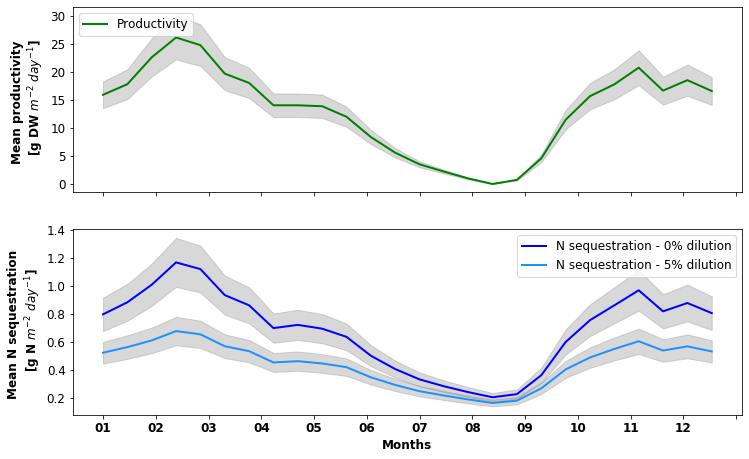

In [19]:
# plot year round yields (biomass production and N removal)

fig, ax = plt.subplots(2,1,figsize=(12,7.5))

plt.rcParams.update({'font.size': 12})

# upper plot - mean biomass yield
v = Mean_biomass_yield_d
data = np.vstack(v)
ax[0].plot(data,linewidth=2,color='g')
ax[0].fill_between(np.arange(data.shape[0]),data.min(axis=1)*.85,data.max(axis=1)*1.15,color='gray',alpha=.3)

# bottom plot - mean N removal yield in a non-diluting environment

v = N_normalized
data = np.vstack(v)
ax[1].plot(data,linewidth=2,color='b')
ax[1].fill_between(np.arange(data.shape[0]),data.min(axis=1)*.85,data.max(axis=1)*1.15,color='gray',alpha=.3)


# bottom plot - mean N removal yield in a diluting environment

v = N_normalized_d
data = np.vstack(v)
ax[1].plot(data,linewidth=2,color='dodgerblue')
ax[1].fill_between(np.arange(data.shape[0]),data.min(axis=1)*.85,data.max(axis=1)*1.15,color='gray',alpha=.3)

# plot graphics
ax[0].set_ylabel('Mean productivity \n [g DW $m^{-2}$ $day^{-1}$]', color='black',fontsize=12, weight="bold")
ax[1].set_ylabel('Mean N sequestration \n [g N $m^{-2}$ $day^{-1}$]', color='black', fontsize=12,weight="bold")
ax[1].set_xlabel('Months', color='black', fontsize=12,weight="bold")

xlabels = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10','11', '12']

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

ax[0].set_xticks(np.linspace(0,26,13))
ax[1].set_xticks(np.linspace(0,26,13))
ax[1].set_xticklabels([str(i) for i in xlabels], fontsize=12, weight="bold")
ax[0].legend(['Productivity'],loc = 'upper left',fontsize='medium')
ax[1].legend(['N sequestration - 0% dilution','N sequestration - 5% dilution'],loc = 'upper right',fontsize='medium')

name = 'fig3.jpg' 
fig.savefig(fname=name, dpi=600)

In [14]:
# Pearson Mean_biomass_yield vs N_normalized 

from scipy.stats import pearsonr 
   
list1 = Mean_biomass_yield_d
list2 = N_normalized
  
# Apply the pearsonr() 
corr, _ = pearsonr(list1, list2) 
print('Pearsons correlation: %.3f' % corr) 
  
# This code is contributed by Amiya Rout 

Pearsons correlation: 0.999


In [ ]:
# Pearson Mean_biomass_yield vs N_normalized in a diluting environment

from scipy.stats import pearsonr 
   
list1 = Mean_biomass_yield_d
list2 = N_normalized_d
  
# Apply the pearsonr() 
corr, _ = pearsonr(list1, list2) 
print('Pearsons correlation: %.3f' % corr) 
  
# This code is contributed by Amiya Rout 